In [34]:
from pathlib import Path

import numpy as np
import pandas as pd
from flaml import AutoML
from sklearn.model_selection import TimeSeriesSplit

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_df = engineer_features(
    sorted_dyads_df,
    stress_lookback_days=0,
    sleep_lookback_range=(0, 1),
)

df_sham = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
# df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=False)
df_treat = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_27314/2571764460.py:11: DtypeWarning: Columns (93,122,123,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [35]:
df_train = df_sham
df_test = df_treat

In [36]:
automl = AutoML()

automl_settings = {
    "time_budget": 15,  # seconds
    # "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
}


X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

[flaml.automl.logger: 12-22 14:28:52] {1752} INFO - task = classification
[flaml.automl.logger: 12-22 14:28:52] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-22 14:28:52] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 12-22 14:28:52] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-22 14:28:52] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-22 14:28:52] {2417} INFO - Estimated sufficient time budget=4339s. Estimated necessary time budget=4s.
[flaml.automl.logger: 12-22 14:28:52] {2466} INFO -  at 1.6s,	estimator xgboost's best error=0.0266,	best estimator xgboost's best error=0.0266
[flaml.automl.logger: 12-22 14:28:52] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-22 14:28:52] {2466} INFO -  at 1.6s,	estimator xgboost's best error=0.0266,	best estimator xgboost's best error=0.0266
[flaml.automl.logger: 12-22 14:28:52] {2282} INFO - iteration 2, cur

In [37]:
import shap
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Fit the model if not already fitted

window = "15m"
X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")
model = XGBClassifier(**automl.best_config)
model.fit(X_train, y_train)


# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.6930


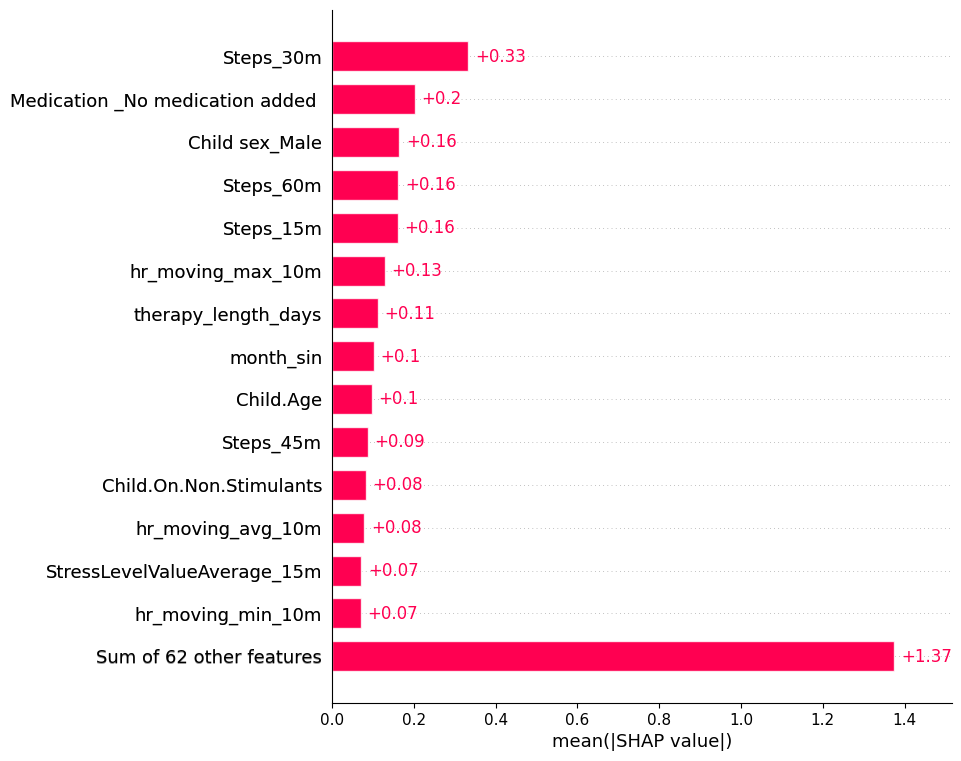

In [38]:
# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=15)

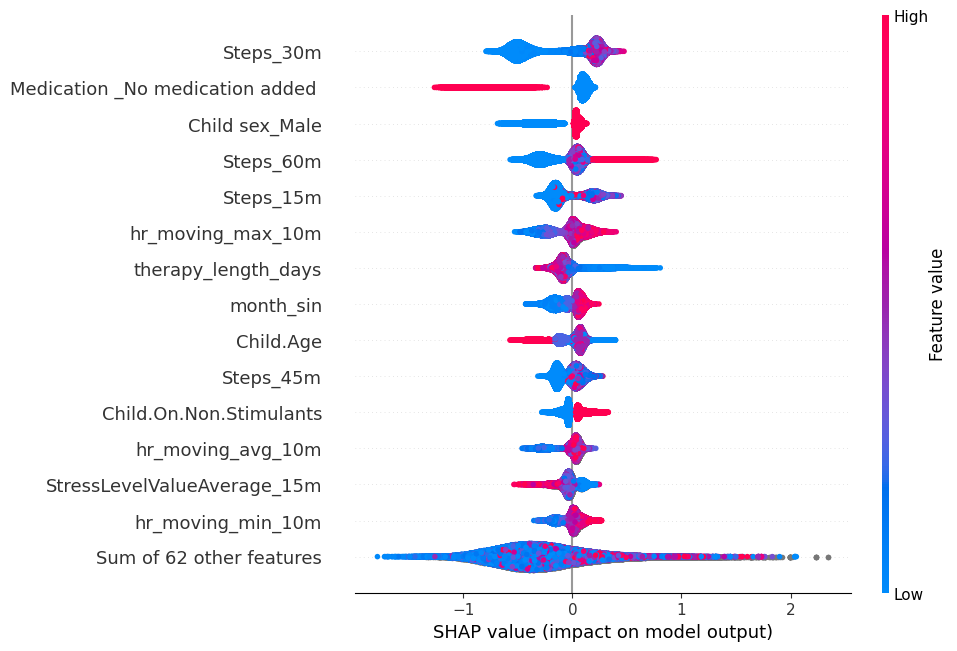

In [39]:
shap.plots.beeswarm(shap_values, max_display=15)

In [40]:
from sklearn.model_selection import train_test_split

df_all = pd.concat([df_sham, df_treat])

df_train, df_test = train_test_split(
    df_all,
    test_size=0.2,
    stratify=df_all["tantrum_within_60m"],
    random_state=42,
    shuffle=True,
)

In [41]:
from flaml import AutoML
from sklearn.model_selection import TimeSeriesSplit

automl = AutoML()

automl_settings = {
    "time_budget": 15,  # seconds
    # "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
    "verbose": False,
}


X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

Best config: {'n_estimators': 127, 'max_leaves': 64, 'min_child_weight': np.float64(0.31791850952237466), 'learning_rate': np.float64(0.04411122499027539), 'subsample': np.float64(0.8413048297641477), 'colsample_bylevel': np.float64(0.430461431952924), 'colsample_bytree': np.float64(0.712906857857845), 'reg_alpha': np.float64(0.0010583588713166411), 'reg_lambda': np.float64(1.8025760820578807)}


In [42]:
import shap
from xgboost import XGBClassifier

# Fit the model if not already fitted

window = "15m"
X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")
model = XGBClassifier(**automl.best_config)
model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [43]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.8475


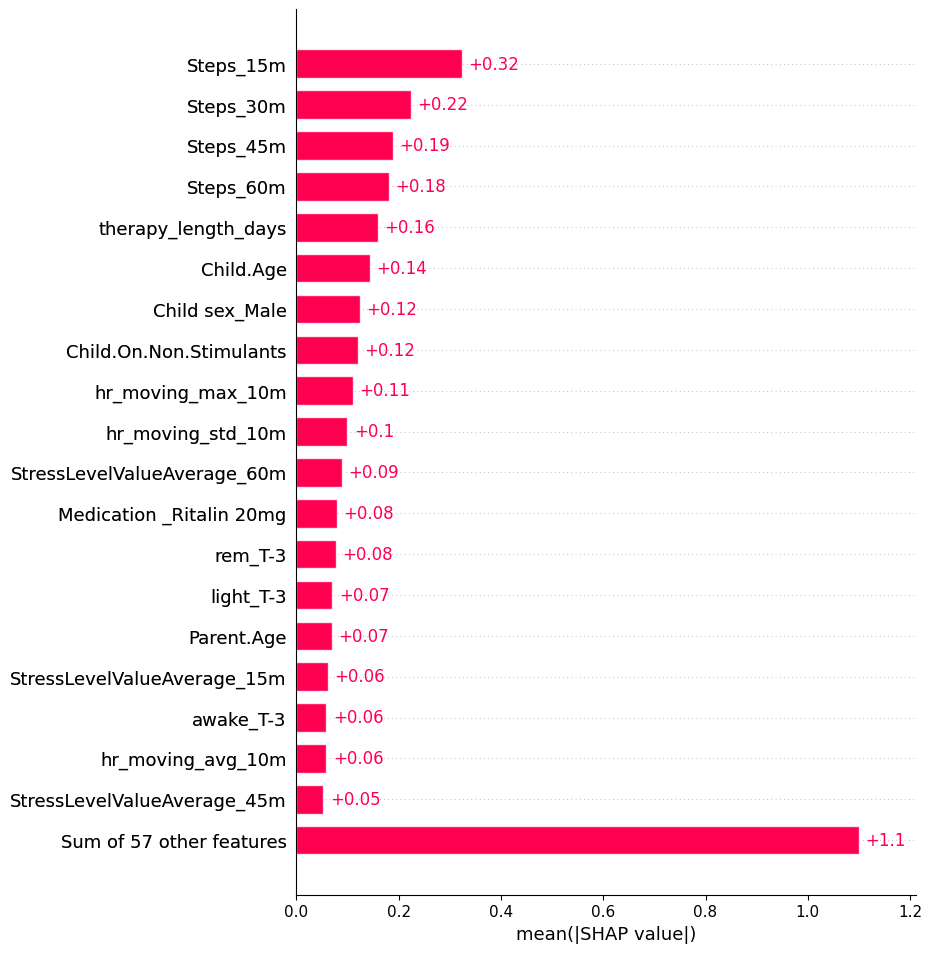

In [44]:
shap.plots.bar(shap_values, max_display=20)

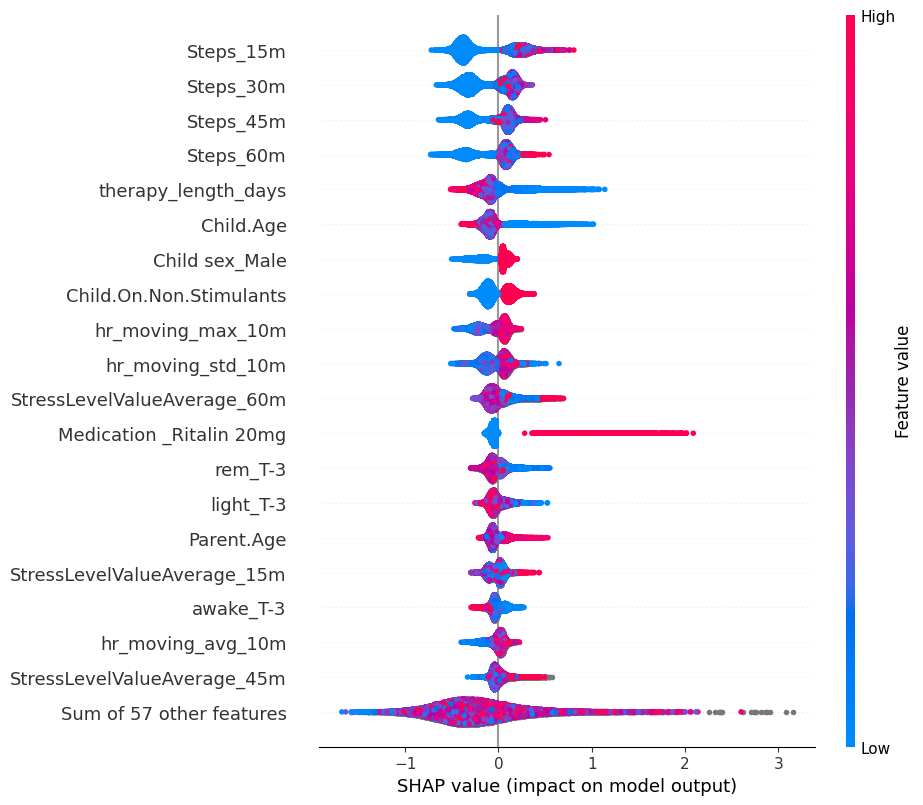

In [45]:
shap.plots.beeswarm(shap_values, max_display=20)